In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub

dataset_path = kagglehub.dataset_download('asdeepak/thermal-images-for-breast-cancer-diagnosis-dmrir')

print(f"Dataset downloaded to: {dataset_path}")


Dataset downloaded to: /kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def preprocess_image(image_path, target_size=(224, 224)):
    try:
        img = load_img(image_path, target_size=target_size, color_mode="grayscale")
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalize to [0,1]
        return img_array.squeeze()  # Remove single channel dimension
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


In [ ]:
# Image preprocessing function
def preprocess_image(image_path, target_size=(224, 224)):
    try:
        img = load_img(image_path, target_size=target_size, color_mode="grayscale")
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalize to [0,1]
        return img_array.squeeze()  # Remove single channel dimension
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Base directories
train_dir = os.path.join(dataset_path, "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia")

# Find the DOENTES and SAUDÁVEIS directories
train_folders = os.listdir(train_dir)
doentes_dir = os.path.join(train_dir, [folder for folder in train_folders if "DOENTES" in folder][0])
saudaveis_dir = os.path.join(train_dir, [folder for folder in train_folders if "SAUD" in folder][0])

# Load images from the "Segmentadas" subdirectories
cancer_images = []
cancer_labels = []
healthy_images = []
healthy_labels = []

# Load cancer images
print("Loading cancer (DOENTES) images...")
for root, dirs, files in os.walk(doentes_dir):
    # Only process files inside "Segmentadas" subdirectories
    if "Segmentadas" in root:
        for file_name in files:
            file_path = os.path.join(root, file_name)

            # Skip non-image files
            if not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                continue

            # Preprocess the image
            img = preprocess_image(file_path)
            if img is not None:
                cancer_images.append(img)
                cancer_labels.append(1)

# Load healthy images
print("Loading healthy (SAUDÁVEIS) images...")
for root, dirs, files in os.walk(saudaveis_dir):
    # Only process files inside "Segmentadas" subdirectories
    if "Segmentadas" in root:
        for file_name in files:
            file_path = os.path.join(root, file_name)

            # Skip non-image files
            if not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                continue

            # Preprocess the image
            img = preprocess_image(file_path)
            if img is not None:
                healthy_images.append(img)
                healthy_labels.append(0)

# Combine datasets
all_images = cancer_images + healthy_images
all_labels = cancer_labels + healthy_labels

# Convert to numpy arrays
X = np.array(all_images)
y = np.array(all_labels)

# Print the shape before conversion
print(f"Dataset shape before RGB conversion: {X.shape}")

# Convert grayscale to RGB (duplicate channels)
if X.ndim == 3:  # If shape is (n, 224, 224)
    X = np.stack([X, X, X], axis=-1)

# Print the shape after conversion
print(f"Dataset shape after RGB conversion: {X.shape}")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Number of cancer samples: {np.sum(y)}")
print(f"Number of healthy samples: {len(y) - np.sum(y)}")


Loading cancer (DOENTES) images...
Loading healthy (SAUDÁVEIS) images...
Dataset shape before RGB conversion: (1282, 224, 224)
Dataset shape after RGB conversion: (1282, 224, 224, 3)
X_train shape: (1025, 224, 224, 3)
X_test shape: (257, 224, 224, 3)
Number of cancer samples: 640
Number of healthy samples: 642


In [ ]:
# Extract features using MobileNetV2
print("Extracting features with MobileNetV2...")

# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

# Extract features
X_train_features = base_model.predict(X_train, batch_size=32, verbose=1)
X_test_features = base_model.predict(X_test, batch_size=32, verbose=1)

print(f"Extracted {X_train_features.shape[1]} features from each image")
print(f"X_train_features shape: {X_train_features.shape}")
print(f"X_test_features shape: {X_test_features.shape}")

Extracting features with MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Extracted 1280 features from each image
X_train_features shape: (1025, 1280)
X_test_features shape: (257, 1280)


In [ ]:
#GA SET UP AND POPULATION INITIALIZATION

# GA parameters
population_size = 20
generations = 10
crossover_rate = 0.8
mutation_rate = 0.1
tournament_size = 3
elite_size = 2
n_features = X_train_features.shape[1]

# Initialize population
print(f"Initializing GA population with {population_size} chromosomes...")
population = []
for _ in range(population_size):
    # Create random binary chromosome
    chromosome = np.random.randint(0, 2, size=n_features)
    # Ensure at least one feature is selected
    if sum(chromosome) == 0:
        chromosome[np.random.randint(0, n_features)] = 1
    population.append(chromosome)

# Track progress
best_chromosome = None
best_fitness = 0
fitness_history = {'best': [], 'avg': [], 'feature_count': []}

print(f"Population initialized with {population_size} chromosomes")
print(f"Each chromosome has {n_features} genes (features)")

Initializing GA population with 20 chromosomes...
Population initialized with 20 chromosomes
Each chromosome has 1280 genes (features)


In [ ]:
#GA HELPER FUNCTIONS TO CREATE MODEL FOR FITNESS EVALUATION

# Function to create model for fitness evaluation
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Function to calculate fitness
def calculate_fitness(chromosome):
    # Get indices of selected features
    selected = np.where(chromosome == 1)[0]

    # If too few features selected, return low fitness
    if len(selected) < 3:
        return 0.1

    # Select features
    X_train_selected = X_train_features[:, selected]
    X_val_selected = X_test_features[:, selected]  # Using test set as validation

    # Create and train model
    model = create_model(len(selected))

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Train model
    history = model.fit(
        X_train_selected, y_train,
        epochs=10,  # Reduced for faster execution in Kaggle
        batch_size=16,
        validation_data=(X_val_selected, y_test),
        callbacks=[early_stopping],
        verbose=0
    )

    # Get validation accuracy as fitness
    val_accuracy = max(history.history['val_accuracy'])

    # Add penalty for using too many features to encourage simpler models
    feature_penalty = 0.001 * (len(selected) / n_features)

    # Final fitness score
    fitness = val_accuracy - feature_penalty

    return fitness

# Function for tournament selection
def select_parent(population, fitness_values):
    tournament_indices = np.random.choice(
        len(population),
        size=tournament_size,
        replace=False
    )
    tournament_fitness = [fitness_values[i] for i in tournament_indices]

    winner_idx = tournament_indices[np.argmax(tournament_fitness)]
    return population[winner_idx].copy()

# Function for crossover
def crossover(parent1, parent2):
    if np.random.random() < crossover_rate:
        # Select two crossover points
        points = sorted(np.random.choice(n_features-1, size=2, replace=False) + 1)

        # Create children
        child1 = np.concatenate([
            parent1[:points[0]],
            parent2[points[0]:points[1]],
            parent1[points[1]:]
        ])

        child2 = np.concatenate([
            parent2[:points[0]],
            parent1[points[0]:points[1]],
            parent2[points[1]:]
        ])

        # Ensure each child has at least one feature
        if sum(child1) == 0:
            child1[np.random.randint(0, n_features)] = 1
        if sum(child2) == 0:
            child2[np.random.randint(0, n_features)] = 1

        return child1, child2
    else:
        return parent1.copy(), parent2.copy()

# Function for mutation
def mutate(chromosome):
    for i in range(n_features):
        if np.random.random() < mutation_rate:
            chromosome[i] = 1 - chromosome[i]  # Flip the bit

    # Ensure at least one feature is selected
    if sum(chromosome) == 0:
        chromosome[np.random.randint(0, n_features)] = 1

    return chromosome


In [ ]:
# Run the genetic algorithm
print(f"Starting GA with population size {population_size}, running for {generations} generations")
print(f"Total features: {n_features}")

for generation in range(generations):
    print(f"Generation {generation+1}/{generations}")

    # Calculate fitness for each chromosome
    fitness_values = [calculate_fitness(chrom) for chrom in population]

    # Get best chromosome in this generation
    best_idx = np.argmax(fitness_values)
    current_best_fitness = fitness_values[best_idx]
    current_best = population[best_idx].copy()
    current_feature_count = sum(current_best)

    # Update overall best if better
    if current_best_fitness > best_fitness:
        best_fitness = current_best_fitness
        best_chromosome = current_best.copy()

    # Store history
    fitness_history['best'].append(current_best_fitness)
    fitness_history['avg'].append(np.mean(fitness_values))
    fitness_history['feature_count'].append(current_feature_count)

    print(f"Best Fitness: {current_best_fitness:.4f}, Features: {current_feature_count}/{n_features}")

    # If last generation, exit loop
    if generation == generations - 1:
        break

    # Elitism - keep best chromosomes
    sorted_indices = np.argsort(fitness_values)[::-1]
    elites = [population[i].copy() for i in sorted_indices[:elite_size]]

    # Create new population
    new_population = elites.copy()

    # Fill remaining population through selection, crossover, mutation
    while len(new_population) < population_size:
        # Select parents
        parent1 = select_parent(population, fitness_values)
        parent2 = select_parent(population, fitness_values)

        # Crossover
        child1, child2 = crossover(parent1, parent2)

        # Mutation
        child1 = mutate(child1)
        child2 = mutate(child2)

        # Add to new population
        new_population.append(child1)
        if len(new_population) < population_size:
            new_population.append(child2)

    # Replace old population
    population = new_population

# Get indices of selected features
selected_features = np.where(best_chromosome == 1)[0]
print(f"\nGA completed. Selected {len(selected_features)}/{n_features} features")

Starting GA with population size 20, running for 10 generations
Total features: 1280
Generation 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Fitness: 0.9995, Features: 617/1280
Generation 2/10
Best Fitness: 0.9995, Features: 601/1280
Generation 3/10
Best Fitness: 0.9995, Features: 591/1280
Generation 4/10
Best Fitness: 0.9995, Features: 594/1280
Generation 5/10
Best Fitness: 0.9995, Features: 592/1280
Generation 6/10
Best Fitness: 0.9995, Features: 592/1280
Generation 7/10
Best Fitness: 0.9995, Features: 587/1280
Generation 8/10
Best Fitness: 0.9996, Features: 574/1280
Generation 9/10
Best Fitness: 0.9996, Features: 574/1280
Generation 10/10
Best Fitness: 0.9996, Features: 575/1280

GA completed. Selected 574/1280 features


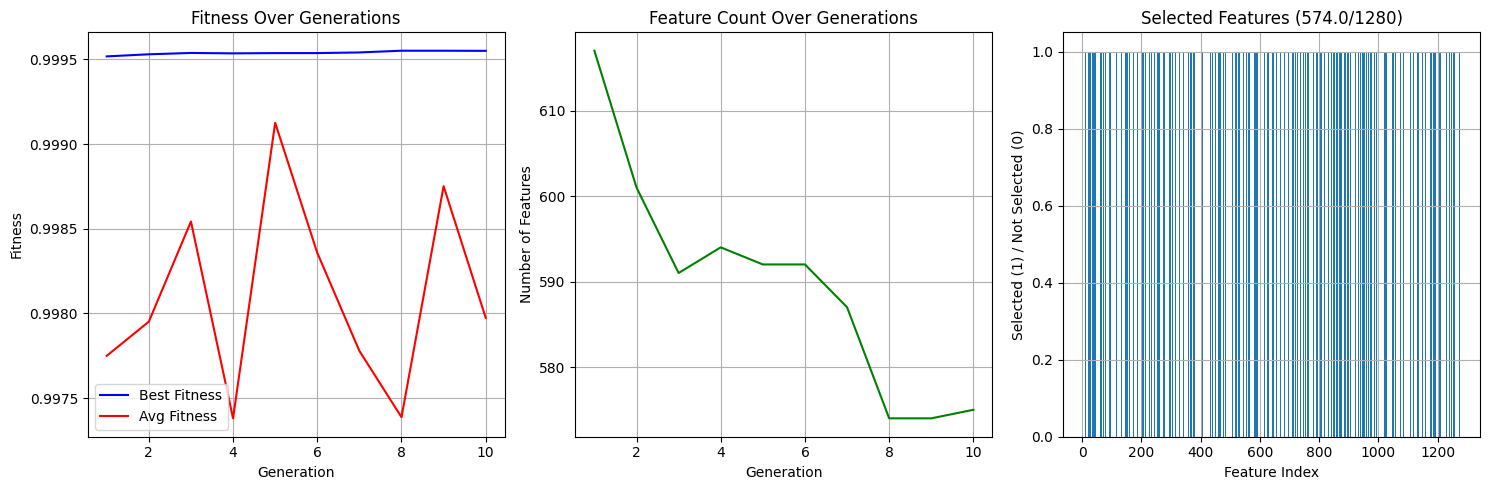

Number of features selected: 574 out of 1280
Selected feature indices (first 20): [ 4  6  7  9 11 12 13 15 17 20 21 22 25 26 28 29 30 31 33 35]


In [ ]:
# Plot the progress of the genetic algorithm
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, len(fitness_history['best'])+1), fitness_history['best'], 'b-', label='Best Fitness')
plt.plot(range(1, len(fitness_history['avg'])+1), fitness_history['avg'], 'r-', label='Avg Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Over Generations')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, len(fitness_history['feature_count'])+1), fitness_history['feature_count'], 'g-')
plt.xlabel('Generation')
plt.ylabel('Number of Features')
plt.title('Feature Count Over Generations')
plt.grid(True)

plt.subplot(1, 3, 3)
selected = np.zeros(n_features)
if best_chromosome is not None:
    selected_indices = np.where(best_chromosome == 1)[0]
    selected[selected_indices] = 1
plt.bar(range(n_features), selected)
plt.xlabel('Feature Index')
plt.ylabel('Selected (1) / Not Selected (0)')
plt.title(f'Selected Features ({sum(selected)}/{n_features})')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print some info about selected features
print(f"Number of features selected: {len(selected_features)} out of {n_features}")
print(f"Selected feature indices (first 20): {selected_features[:20]}")



Training final model with selected features...
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6130 - loss: 0.6517 - val_accuracy: 0.8833 - val_loss: 0.3491
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8299 - loss: 0.3853 - val_accuracy: 0.9066 - val_loss: 0.2273
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8796 - loss: 0.2813 - val_accuracy: 0.9416 - val_loss: 0.1432
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9195 - loss: 0.1941 - val_accuracy: 0.9611 - val_loss: 0.0991
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9382 - loss: 0.1447 - val_accuracy: 0.9805 - val_loss: 0.0735
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9759 - loss: 0.1066 - val_accuracy: 0.9922 - val_loss: 0.0479
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9748 - loss: 0.0811 - val_accuracy: 0.9728 - val_loss: 0.0582
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9776 -

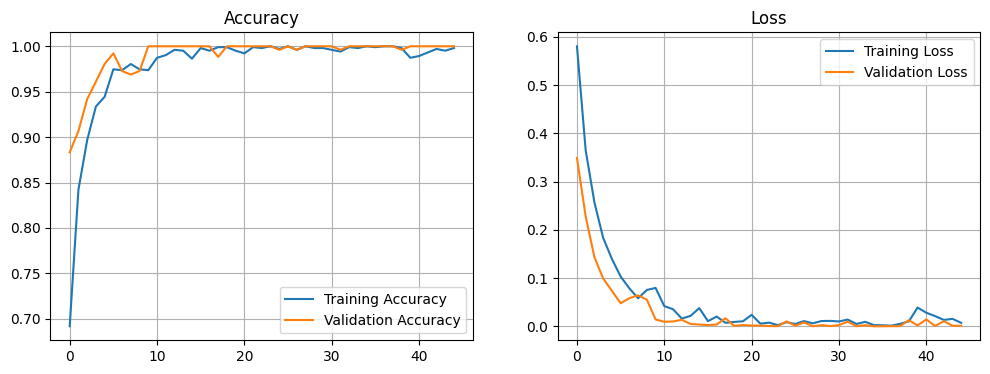

In [ ]:
# Train final model with selected features
print("\nTraining final model with selected features...")
X_train_selected = X_train_features[:, selected_features]
X_test_selected = X_test_features[:, selected_features]

# Create final model
final_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(len(selected_features),)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

final_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train with early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = final_model.fit(
    X_train_selected, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_selected, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.grid(True)
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       117
      Cancer       1.00      1.00      1.00       140

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257



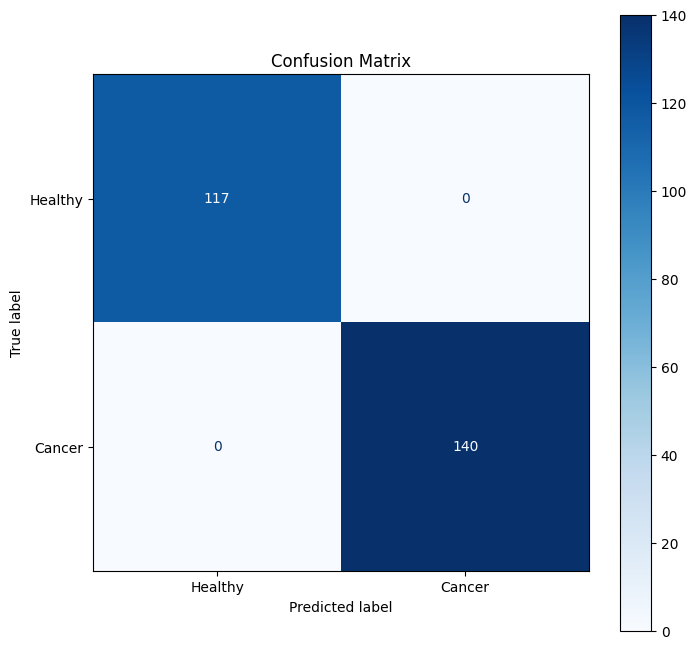

In [ ]:
# Evaluate the model
y_pred_probs = final_model.predict(X_test_selected)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Cancer']))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Cancer'])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
